# Introduction

In [1]:
"""
What? NLP in the Stock Market

Reference: https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92
"""

'\nWhat? NLP in the Stock Market\n\nRevision No: 2\nLast revised: 25/03/21\nReference: https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92\nGLM\n'

# Modules installtion issues

In [2]:
"""
Attention if you are on MAC please make sure you do:
pip install bs4
pip install html5lib
pip install lxml

Reference: https://stackoverflow.com/questions/24398302/bs4-featurenotfound-couldnt-find-a-tree-builder-with-the-features-you-requeste
"""

'\nAttention if you are on MAC please make sure you do:\npip install bs4\npip install html5lib\npip install lxml\n\nReference: https://stackoverflow.com/questions/24398302/bs4-featurenotfound-couldnt-find-a-tree-builder-with-the-features-you-requeste\n'

# Import

In [46]:
import nltk, os
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download NLP Corpora

In [4]:
"""
You'll need two corpora to run this project: 
    [1] stopwords corpus for removing stopwords 
    [2] wordnet for lemmatizing.
"""

"\nYou'll need two corpora to run this project: \n    [1] stopwords corpus for removing stopwords \n    [2] wordnet for lemmatizing.\n"

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Get 10ks

In [6]:
"""
Financial documents such as 10-k forms can be used to forecast stock movements. 10-k forms are annual reports 
filed by companies to provide a comprehensive summary of their financial performance.

10-k documents include information such as company history, organizational structure, executive compensation, 
equity, subsidiaries, and audited financial statements. Each company has an unique CIK (Central Index Key).
In this case  we selected 7 of them to keep the computation low.
"""

'\nFinancial documents such as 10-k forms can be used to forecast stock movements. 10-k forms are annual reports \nfiled by companies to provide a comprehensive summary of their financial performance.\n\n10-k documents include information such as company history, organizational structure, executive compensation, \nequity, subsidiaries, and audited financial statements. Each company has an unique CIK (Central Index Key).\nIn this case  we selected 7 of them to keep the computation low.\n'

In [7]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

additional_cik = {
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

# Get list of 10-ks

In [8]:
"""
The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that 
limit, we've created the SecAPI class. This will cache data from the SEC and prevent you from going over the limit.
"""

"\nThe SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that \nlimit, we've created the SecAPI class. This will cache data from the SEC and prevent you from going over the limit.\n"

In [9]:
sec_api = project_helper.SecAPI()

In [10]:
def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]

    return entries

In [11]:
"""
Let's pull the list using the get_sec_data function, then display some of the results. For displaying some of 
the data, we'll use Amazon as an example.
"""

"\nLet's pull the list using the get_sec_data function, then display some of the results. For displaying some of \nthe data, we'll use Amazon as an example.\n"

In [12]:
example_ticker = 'AMZN'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')
    
pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/1018724/000101872421000004/0001018724-21-000004-index.htm',
  '10-K',
  '2021-02-03'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872420000004/0001018724-20-000004-index.htm',
  '10-K',
  '2020-01-31'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872419000004/0001018724-19-000004-index.htm',
  '10-K',
  '2019-02-01'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872418000005/0001018724-18-000005-index.htm',
  '10-K',
  '2018-02-02'),
 ('https://www.sec.gov/Archives/edgar/data/1018724/000101872417000011/0001018724-17-000011-index.htm',
  '10-K',
  '2017-02-10')]


# Download 10-ks

In [13]:
"""
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. 
Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.
"""

"\nAs you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. \nSince we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.\n"

In [14]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0001018724-21-000004.txt : 20210203
<SEC-HEADER>0001018724-21-000004.hdr.sgml : 20210203
<ACCEPTANCE-DATETIME>20210202194410
ACCESSION NUMBER:		0001018724-21-000004
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		107
CONFORMED PERIOD OF REPORT:	20201231
FILED AS OF DATE:		20210203
DATE AS OF CHANGE:		20210202

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			AMAZON COM INC
		CENTRAL INDEX KEY:			0001018724
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-CATALOG & MAIL-ORDER HOUSES [5961]
		IRS NUMBER:				911646860
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-22513
		FILM NUMBER:		21583589

	BUSINESS ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
		BUSINESS PHONE:		2062661000

	MAIL ADDRESS:	
		STREET 1:		410 TERRY AVENUE NORTH
		CITY:			SEATTLE
		STATE:			WA
		ZIP:			98109
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<

# Get documens

In [15]:
"""
With theses fillings downloaded, we want to break them into their associated documents. These documents are 
sectioned off in the fillings with the tags <DOCUMENT> for the start of each document and </DOCUMENT> for the 
end of each document. There's no overlap with these documents, so each </DOCUMENT> tag should come after the 
<DOCUMENT> with no <DOCUMENT> tag in between.

Implement get_documents to return a list of these documents from a filling. Make sure not to include the tag in 
the returned document text.
"""

"\nWith theses fillings downloaded, we want to break them into their associated documents. These documents are \nsectioned off in the fillings with the tags <DOCUMENT> for the start of each document and </DOCUMENT> for the \nend of each document. There's no overlap with these documents, so each </DOCUMENT> tag should come after the \n<DOCUMENT> with no <DOCUMENT> tag in between.\n\nImplement get_documents to return a list of these documents from a filling. Make sure not to include the tag in \nthe returned document text.\n"

In [16]:
def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """

    # TODO: Implement
    extracted_docs = []

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]

    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
        extracted_docs.append(text[doc_start_i:doc_end_i])

    return extracted_docs

In [17]:
"""
With the get_documents function implemented, let's extract all the documents.
"""

"\nWith the get_documents function implemented, let's extract all the documents.\n"

In [18]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from HON Fillings: 100%|██████████| 24/24 [00:01<00:00, 17.23filling/s]

Document 0 Filed on 2021-02-03:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>amzn-20201231.htm
<DESCRIPTION>10-K
<TEXT>
<XBRL>
<?xml version="1.0" ?><!--XBRL Document Created with Wdesk from Workiva--><!--Copyright 2021 Workiva--><!--r:552820d...

Document 1 Filed on 2021-02-03:

<TYPE>EX-21.1
<SEQUENCE>2
<FILENAME>amzn-20201231xex211.htm
<DESCRIPTION>EXHIBIT 21.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"><htm...

Document 2 Filed on 2021-02-03:

<TYPE>EX-23.1
<SEQUENCE>3
<FILENAME>amzn-20201231xex231.htm
<DESCRIPTION>EXHIBIT 23.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd"><htm...


# Get Document Types

In [19]:
"""
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the 
get_document_type function to return the type of document given. The document type is located on a line 
with the <TYPE> tag. For example, a form of type "TEST" would have the line <TYPE>TEST. Make sure to return 
the type as lowercase, so this example would be returned as "test".
"""

'\nNow that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the \nget_document_type function to return the type of document given. The document type is located on a line \nwith the <TYPE> tag. For example, a form of type "TEST" would have the line <TYPE>TEST. Make sure to return \nthe type as lowercase, so this example would be returned as "test".\n'

In [20]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """

    # TODO: Implement
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_type = type_pattern.findall(doc)[0][len('<TYPE>'):]

    return doc_type.lower()

In [21]:
"""
With the get_document_type function, we'll filter out all non 10-k documents.
"""

"\nWith the get_document_type function, we'll filter out all non 10-k documents.\n"

In [22]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], [
                                'cik', 'file', 'file_date'])

[
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2020123...
    file_date: '2021-02-03'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2019123...
    file_date: '2020-01-31'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2018123...
    file_date: '2019-02-01'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2017123...
    file_date: '2018-02-02'},
  {
    cik: '0001018724'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>amzn-2016123...
    file_date: '2017-02-10'},
]


# Document clean-up

In [23]:
"""
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase 
all the text.
"""

"\nAs you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase \nall the text.\n"

In [24]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

In [25]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning HON 10-Ks: 100%|██████████| 24/24 [01:09<00:00,  2.90s/10-K]

[
  {
    file_clean: '\n10-k\n1\namzn-20201231.htm\n10-k\n\n\n\namzn-20...},
  {
    file_clean: '\n10-k\n1\namzn-20191231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20181231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20171231x10k.htm\n10-k\n\n\n\n\n\...},
  {
    file_clean: '\n10-k\n1\namzn-20161231x10k.htm\nform 10-k\n\n\n...},
]


# Lemmatize

In [26]:
"""
With the text cleaned up, it's time to distill the verbs down. Implement the lemmatize_words function to lemmatize 
verbs in the list of words provided.
"""

"\nWith the text cleaned up, it's time to distill the verbs down. Implement the lemmatize_words function to lemmatize \nverbs in the list of words provided.\n"

In [27]:
def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """

    # TODO: Implement
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v')
                        for word in words]

    return lemmatized_words

In [28]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize HON 10-Ks: 100%|██████████| 24/24 [00:04<00:00,  5.3910-K/s]

[
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20201231', 'htm', '10',...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20191231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20181231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20171231x10k', 'htm', '...},
  {
    file_lemma: '['10', 'k', '1', 'amzn', '20161231x10k', 'htm', '...},
]


# Remove Stopwords

In [29]:
lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for HON 10-Ks: 100%|██████████| 24/24 [00:02<00:00, 10.1510-K/s]

Stop Words Removed


# Loughran McDonald Sentiment Word Lists

In [ ]:
"""
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:

    Negative
    Positive
    Uncertainty
    Litigious
    Constraining
    Superfluous
    Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be 
looking into a few of these sentiments.

The dataset was retrievd from here: https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists
"""

In [32]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv(os.path.join('./LoughranMcDonald_MasterDictionary_2018.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


# Bag of Words

In [ ]:
"""
Using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement 
get_bag_of_words to generate a bag of words that counts the number of sentiment words in each doc. You can 
ignore words that are not in sentiment_words.
"""

In [34]:
def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]

    return bag_of_words.astype(int)

In [ ]:
"""
Using the get_bag_of_words function, we'll generate a bag of words for all the documents.
"""

In [36]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 1 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[13  0  0 ...  0  0  0]\n [12  0  0 ...  0  0  0...
    uncertainty: '[[0 0 0 ... 1 1 4]\n [0 0 0 ... 1 1 2]\n [0 0 0 ....
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 2]\n [0 0 0 ... 0 0 2]\n [0 0 0 ....
    interesting: '[[2 0 0 ... 0 0 0]\n [2 0 0 ... 0 0 0]\n [2 0 0 ....},
]


# Jaccard Similarity

In [ ]:
"""
Using the bag of words, let's calculate the jaccard similarity on the bag of words and plot it over time. 
Implement get_jaccard_similarity to return the jaccard similarities between each tick in time. Since the input,
bag_of_words_matrix, is a bag of words for each time period in order, you just need to compute the jaccard 
similarities for each neighboring bag of words. Make sure to turn the bag of words into a boolean array when
calculating the jaccard similarity.
"""

In [40]:
def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    jaccard_similarities = []
    bag_of_words_matrix = np.array(bag_of_words_matrix, dtype=bool)
    
    for i in range(len(bag_of_words_matrix)-1):
            u = bag_of_words_matrix[i]
            v = bag_of_words_matrix[i+1]
            jaccard_similarities.append(jaccard_score(u,v))    
    
    return jaccard_similarities

In [ ]:
"""
Using the get_jaccard_similarity function, let's plot the similarities over time.
"""

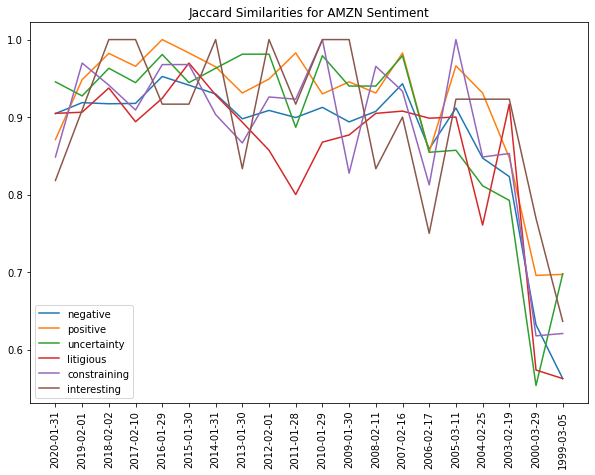

In [41]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

# TFIDF

In [ ]:
"""
Using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement get_tfidf to 
generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in 
sentiment_words.
"""

In [43]:
def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

In [45]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0.         0.02913113 0.         ... 0.        ...
    positive: '[[0.22686214 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.00603136...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.02036571 0.         0.         ... 0.        ...},
]


# Cosine Similarity

In [ ]:
"""
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement 
get_cosine_similarity to return the cosine similarities between each tick in time. Since the input, tfidf_matrix, 
is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each 
neighboring vector.
"""

In [47]:
def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    cosine_similarities = []    
    
    for i in range(len(tfidf_matrix)-1):
        cosine_similarities.append(cosine_similarity(tfidf_matrix[i].reshape(1, -1),tfidf_matrix[i+1].reshape(1, -1))[0,0])
    
    return cosine_similarities

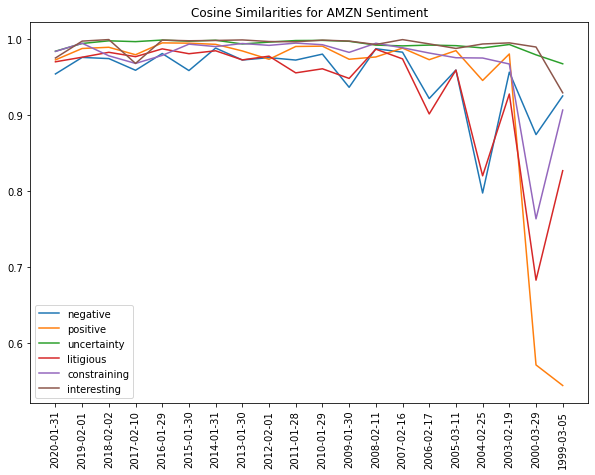

In [48]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

# Price Data

In [ ]:
"""
Let's evaluate the alpha factors. For this section, we'll just be looking at the cosine similarities, but it can 
be applied to the jaccard similarities as well.
"""

In [50]:
pricing = pd.read_csv('./quotemedia.csv', parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')

pricing

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478,50.863198,31.425388,64.694095,46.235,39.913360,...,27.668791,35.288928,76.320802,40.023873,22.106665,25.753386,45.480383,71.898827,27.858587,29.447893
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076,50.696766,31.272881,64.712041,46.030,39.860576,...,27.542284,35.059033,76.608168,39.965530,22.082740,25.613675,45.402661,72.934172,28.038932,28.572441
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862,50.937167,30.725650,65.214519,46.420,40.186077,...,27.334452,35.280086,76.650427,40.004426,22.202365,25.734758,46.063299,72.301458,28.181310,28.168387
2013-07-05,30.434568,16.214608,81.821882,54.173381,35.856134,51.371737,31.326707,66.075911,47.000,40.652334,...,27.695899,35.801771,77.394196,40.675380,22.585164,26.060750,46.413048,73.164246,29.396267,29.024598
2013-07-08,30.524021,16.310894,82.951417,53.865799,36.661889,52.037461,31.766285,66.820655,46.625,40.256455,...,27.985057,35.200507,77.968926,40.646208,22.489464,26.228403,46.950626,73.892823,29.576612,29.765365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-26,58.578545,48.362348,121.521592,143.572709,70.355209,94.310434,47.952274,120.091012,144.960,78.926776,...,42.768925,65.995879,78.125436,63.566740,27.954615,54.057499,73.499346,127.972643,41.755545,62.430093
2017-06-27,58.222564,48.084745,121.691217,141.514919,70.016684,93.858483,47.716973,119.943770,142.540,76.546336,...,43.141511,63.781646,78.000420,63.923912,27.753502,53.879548,72.742128,127.169467,41.952785,62.469909
2017-06-28,58.736758,48.828324,116.452788,143.582555,70.529308,94.693610,47.530694,121.465276,143.810,77.584717,...,43.308194,64.673218,78.404318,64.824284,28.289802,54.344197,72.919140,127.427277,42.376849,62.659030


# Dict to DataFrame

In [51]:
cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


for ticker, ten_k_sentiments in cosine_similarities.items():
    for sentiment_name, sentiment_values in ten_k_sentiments.items():
        for sentiment_values, sentiment_value in enumerate(sentiment_values):
            cosine_similarities_df_dict['ticker'].append(ticker)
            cosine_similarities_df_dict['sentiment'].append(sentiment_name)
            cosine_similarities_df_dict['value'].append(sentiment_value)
            cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')


cosine_similarities_df.head()

,date,ticker,sentiment,value
0,2020-01-01,AMZN,negative,0.954314
1,2019-01-01,AMZN,negative,0.976092
2,2018-01-01,AMZN,negative,0.974540
3,2017-01-01,AMZN,negative,0.959161
4,2016-01-01,AMZN,negative,0.981197


# Alphalens Format

In [ ]:
"""
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix
timestamp. In this next cell, we'll do just that.
"""

In [67]:
import alphalens as al


factor_data = {}
skipped_sentiments = []
print(sentiments)

for sentiment in sentiments:
    cs_df = cosine_similarities_df[(cosine_similarities_df['sentiment'] == sentiment)]
    cs_df = cs_df.pivot(index='date', columns='ticker', values='value')
    
    try:
        data = al.utils.get_clean_factor_and_forward_returns(cs_df.stack(), pricing.loc[cs_df.index], quantiles=5, bins=None, periods=[1])
        factor_data[sentiment] = data
    except:
        skipped_sentiments.append(sentiment)        

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))
factor_data[sentiments[0]].head()

['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

Skipped the following sentiments:
negative
positive
uncertainty
litigious
constraining
interesting


KeyError: 'negative'

In [66]:
factor: data.set_index(pd.MultiIndex.from_tuples(
    [(x.timestamp(), y) for x, y in data.index.values],
    names=['date', 'asset']))
for factor, data in factor_data.items()}

AttributeError: 'list' object has no attribute 'set_index'

In [ ]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()